# 11 Control – State-Space & Optimal Linear

In the previous chapter, we explored classical feedback control, including its historical perspectives, the anatomy of control loops, stability margins, and techniques for tuning proportional-integral-derivative (PID) controllers using root-locus and frequency-domain methods. These approaches are particularly effective for single-input single-output (SISO) systems and provide intuitive tools for understanding system behavior in the frequency domain. Building on this foundation, we now transition to state-space methods, which offer a more general framework for analyzing and controlling multi-input multi-output (MIMO) systems, including those with non-zero initial conditions or nonlinear dynamics.

Recall from Chapter 3, where we discussed model classification with a focus on nonlinearity and chaos, the concept of state-space as a way to represent the internal "memory" or configuration of a dynamic system. For instance, in the logistic map or other chaotic systems, the state at any time encapsulates all the information needed to predict future behavior. Here, we extend this idea to control systems, emphasizing computational tools to handle linear time-invariant (LTI) representations and optimal control strategies. While Chapter 3 touched on these concepts informally through examples like fixed points and limit cycles, we will now formalize them in the context of control engineering, preparing for numerical implementations in Python.


## 11.1 Introduction

This chapter introduces state-space representation and optimal linear control techniques, focusing on the Linear Quadratic Regulator (LQR) and Kalman filtering. We will explore how to model systems in state-space form, analyze their properties (such as controllability, observability, and stability), and design optimal controllers and estimators. A key distinction is between the SISO systems emphasized in Chapter 10 and the MIMO systems naturally handled by state-space control. Unlike the frequency-domain approach, which is typically limited to linear systems with zero initial conditions, state-space methods extend to a broader class of problems, including those with initial states $  \mathbf{y}(0) \neq \mathbf{0}  $ and, through extensions like the Extended Kalman Filter (EKF), even nonlinear dynamics. Throughout, we will use Python libraries such as SciPy and NumPy for practical computations, aligning with the course's emphasis on numerical methods in space engineering applications.

## 11.2 State-Space Representation

State-space representation provides a compact and versatile way to model dynamic systems, particularly those that are multi-input multi-output (MIMO) or have non-zero initial conditions. Unlike the transfer function or frequency-domain approaches discussed in Chapter 10, which are well-suited for single-input single-output (SISO) linear systems with zero initial states, state-space models capture the internal dynamics through a vector of state variables. As we have highlighted in earlier chapters in this course the state-space forms enable efficient numerical simulation, analysis, and control design using tools like SciPy.

> #### Definition: State-Space Model
> As usual, we denote the dynamic state vector as $  \mathbf{y}(t) \in \mathbb{R}^n  $, where $  n  $ is the number of states (degrees of freedom in the system's "memory"). Control inputs are $  \mathbf{u}(t) \in \mathbb{R}^m  $, outputs (measurements) are $  \mathbf{z}(t) \in \mathbb{R}^p  $, and the system is governed by matrices $  \mathbf{A} \in \mathbb{R}^{n \times n}  $ (state matrix), $  \mathbf{B} \in \mathbb{R}^{n \times m}  $ (input matrix), $  \mathbf{C} \in \mathbb{R}^{p \times n}  $ (output matrix), and $  \mathbf{D} \in \mathbb{R}^{p \times m}  $ (feedthrough matrix). For simplicity, we assume continuous-time systems here, though discrete-time extensions will be introduced later.
The formal state-space equations are:
>
> $$\frac{dy}{dt}= \mathbf{A} \mathbf{y}(t) + \mathbf{B} \mathbf{u}(t)$$
>
> $$\mathbf{z}(t) = \mathbf{C} \mathbf{y}(t) + \mathbf{D} \mathbf{u}(t)$$
>
> These represent ordinary differential equations (ODEs) for the state evolution and algebraic relations for the outputs (which can be solve with the usual methods as introduced in Chapters 4-6). In the absence of direct feedthrough ($  \mathbf{D} = \mathbf{0}  $), the outputs depend only on the current state.



### 11.2.1 Fundamentals of State-Space Models
The dynamic state vector $  \mathbf{y}(t)  $ encapsulates all necessary information to predict the future behavior of the system given the inputs $  \mathbf{u}(t)  $ and initial conditions $  \mathbf{y}(0)  $. This is particularly useful for systems with coupled dynamics, as seen in space engineering applications like satellite attitude control or orbital mechanics, where states might include position, velocity, and orientation.

Key components:

- States ($  \mathbf{y}  $): Internal variables, often not directly measurable (e.g., angular velocities in a spacecraft).
- Inputs ($  \mathbf{u}  $): External actuators or disturbances (e.g., thruster forces).
- Outputs ($  \mathbf{z}  $): Measured quantities (e.g., sensor readings like gyro rates).
- Matrices: $  \mathbf{A}  $ describes free evolution (e.g., system inertia), $  \mathbf{B}  $ maps inputs to state changes, $  \mathbf{C}  $ extracts outputs from states, and $  \mathbf{D}  $ handles instantaneous input-output coupling.

State-space models can represent both linear and nonlinear systems, but we focus on linear forms here. Nonlinear extensions (e.g., $  \frac{d\mathbf{y}}{dt} = \mathbf{f}(\mathbf{y}, \mathbf{u})  $) will appear in later chapters on model-predictive control (MPC) and reinforcement learning (RL).



> #### Example: Conversion from Classical to State-Space Forms
> Consider a second-order SISO system from Chapter 10, such as a mass-spring-damper with transfer function $  G(s) = \frac{1}{s^2 + 2\zeta \omega_n s + \omega_n^2}  $, where $  \zeta  $ is damping ratio and $  \omega_n  $ natural frequency. This can be converted to state-space form by choosing states as position $  y_1 = x  $ (displacement) and velocity $  y_2 = \frac{dx}{dt}  $, with input $  u = f  $ (force).
> The equations become:\
>
> $$\frac{dy_1}{dt} = y_2$$
>
> $$\frac{dy_2}{dt} = -\omega_n^2 y_1 - 2\zeta \omega_n y_2 + u$$
>
> In matrix form:
>
> $$\frac{d\mathbf{y}}{dt} = \begin{bmatrix} 0 & 1 \\ -\omega_n^2 & -2\zeta \omega_n \end{bmatrix} \mathbf{y} + \begin{bmatrix} 0 \\ 1 \end{bmatrix} u$$
>
> $$\mathbf{z} = \begin{bmatrix} 1 & 0 \end{bmatrix} \mathbf{y}$$
>
> (assuming output is position, $  \mathbf{D} = 0  $). This is known as the controllable canonical form. Other realizations (e.g., observable canonical) exist, but all are equivalent up to coordinate transformations.

For space engineering context, imagine a simplified satellite attitude control: states could be angle $  \theta  $ and angular rate $  \frac{d\theta}{dt}  $, input torque $  \tau  $, with $  \mathbf{A} = \begin{bmatrix} 0 & 1 \\ 0 & 0 \end{bmatrix}  $, $  \mathbf{B} = \begin{bmatrix} 0 \\ 1/I \end{bmatrix}  $ (where $  I  $ is moment of inertia).

To convert symbolically in Python using SymPy:

In [1]:
import sympy as sp

omega_n, zeta = sp.symbols('omega_n zeta')
A = sp.Matrix([[0, 1], [-omega_n**2, -2*zeta*omega_n]])
B = sp.Matrix([[0], [1]])
C = sp.Matrix([[1, 0]])
D = sp.Matrix([[0]])

display(A, B, C, D)

Matrix([
[          0,               1],
[-omega_n**2, -2*omega_n*zeta]])

Matrix([
[0],
[1]])

Matrix([[1, 0]])

Matrix([[0]])

This displays the matrices for inspection.

### 11.2.2 Linear Time-Invariant (LTI) Systems

An LTI system satisfies linearity (superposition) and time-invariance (shift-invariant responses). In state-space, this means constant matrices $  \mathbf{A}, \mathbf{B}, \mathbf{C}, \mathbf{D}  $. The solution for the state trajectory is:

$$\mathbf{y}(t) = e^{\mathbf{A}t} \mathbf{y}(0) + \int_0^t e^{\mathbf{A}(t-\tau)} \mathbf{B} \mathbf{u}(\tau) \, d\tau$$

where $  e^{\mathbf{A}t}  $ is the matrix exponential (computed numerically via SciPy). LTI systems enable eigenvalue analysis for stability: if all eigenvalues of $  \mathbf{A}  $ have negative real parts, the unforced system ($  \mathbf{u}=\mathbf{0}  $) is asymptotically stable.

For MIMO systems, LTI forms handle interactions naturally, unlike SISO PID tuning. In space applications, LTI approximations are common for small perturbations around equilibria (e.g., linearized orbital dynamics via Clohessy-Wiltshire equations).



### 11.2.3  Implementing LTI Systems with SciPy

SciPy's scipy.signal module provides the StateSpace class for LTI simulation. For numerical integration, use scipy.integrate.solve_ivp on the state equations.

> #### Example: Using scipy.integrate.solve_ivp for LTI Simulation
>
> For custom inputs or nonlinear extensions, define the ODE function:

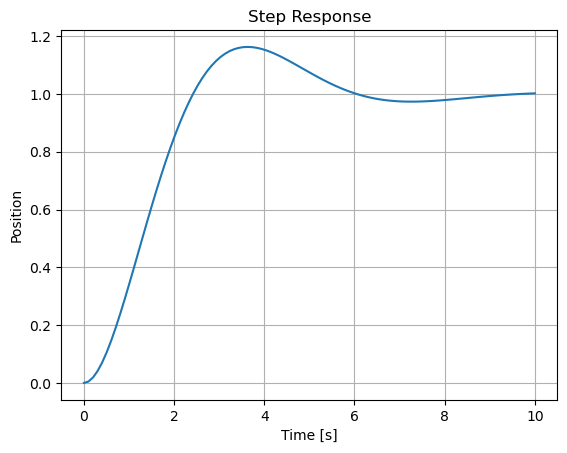

In [2]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

def state_eq(t, y, A, B, u_func):
    return A @ y + B.squeeze() * u_func(t)

# Step input
def u_step(t): return 1.0 if t > 0 else 0.0

# Define matrices
A = np.array([[0, 1], [-1, -1]])  # omega_n=1, zeta=0.5
B = np.array([[0], [1]])
C = np.array([[1, 0]])
D = np.array([[0]])

# Simulate step response

sol = solve_ivp(state_eq, [0, 10], [0, 0], args=(A, B, u_step), t_eval=np.linspace(0, 10, 100))

# plot results
plt.plot(sol.t, sol.y[0])
plt.xlabel('Time [s]')
plt.ylabel('Position')
plt.title('Step Response')
plt.grid()
plt.show()

We will use a standard function to plot step responses for various systems throughout this chapter:

In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def plot_step_response(A, C, B=None, D=None, title='Step Response', t_end=10):
    if B is None:
        B = np.array([[0], [1]])
    if D is None:
        D = np.array([[0]])

    def state_eq(t, y, A, B, u_func):
        return A @ y + B.squeeze() * u_func(t)

    def u_step(t):
        return 1.0 if t > 0 else 0.0

    t_span = [0, t_end]
    t_eval = np.linspace(0, t_end, 100)
    y0 = np.zeros(A.shape[0])

    sol = solve_ivp(state_eq, t_span, y0, args=(A, B, u_step), t_eval=t_eval)

    u_values = np.array([u_step(t) for t in sol.t]).reshape(1, -1)
    z = (C @ sol.y).squeeze() + (D @ u_values).squeeze()

    plt.plot(sol.t, z)
    plt.xlabel('Time [s]')
    plt.ylabel('Output')
    plt.title(title)
    plt.grid()
    plt.show()

## 11.3 System Properties
Once a system is modeled in state-space form, analyzing its inherent properties is crucial for effective control design. These properties determine whether the system can be controlled to achieve desired behaviors, whether its internal states can be inferred from measurements, and how stable it is under various conditions. In this section, we focus on computational methods to assess controllability, observability, and stability using tools like NumPy and SciPy. We also introduce interaction analysis for MIMO systems via Relative Gain Arrays (RGA), which helps in understanding cross-couplings and selecting appropriate input-output pairings. Finally, we optionally explore decoupling strategies to mitigate interactions in MIMO control.

These analyses are particularly relevant in space engineering, where systems like spacecraft attitude dynamics often involve multiple coupled states and actuators (e.g., reaction wheels or thrusters). We will use numerical examples throughout, building on the mass-spring-damper and satellite attitude models from Section 11.2.


### 11.3.1 Controllability

Controllability assesses whether the system's states $  \mathbf{y}(t)  $ can be driven from any initial condition $  \mathbf{y}(0)  $ to any desired final state $  \mathbf{y}(t_f)  $ in finite time using the inputs $  \mathbf{u}(t)  $. For LTI systems, this is determined by the rank of the controllability matrix.

> **Definition:** The **controllability matrix** $  \mathbf{C}_m  $ for an LTI system with matrices $  \mathbf{A} \in \mathbb{R}^{n \times n}  $ and $  \mathbf{B} \in \mathbb{R}^{n \times m}  $ is defined as:
>
> $$\mathbf{C}_m = \begin{bmatrix} \mathbf{B} & \mathbf{A B} & \mathbf{A}^2 \mathbf{B} & \cdots & \mathbf{A}^{n-1} \mathbf{B} \end{bmatrix} \in \mathbb{R}^{n \times (n m)}$$
>
> The system is controllable if $\operatorname{rank}(\mathbf{C}_m) = n$, meaning the matrix has full row rank. This ensures that the inputs can influence all states independently.

In practice, compute $  \mathbf{C}_m  $ using matrix powers and check its rank with NumPy. Numerical stability is important; use singular value decomposition (SVD) via np.linalg.svd to assess effective rank, as small singular values may indicate near-uncontrollability due to conditioning issues.





> #### Example: Checking Controllability of a Satellite Attitude Model
> Consider the simplified satellite attitude system from Section 11.2: $  \mathbf{A} = \begin{bmatrix} 0 & 1 \\ 0 & 0 \end{bmatrix}  $, $  \mathbf{B} = \begin{bmatrix} 0 \\ 1/I \end{bmatrix}  $ (with $  I = 1  $ for simplicity). This double integrator represents angle $  \theta = y_1  $ and rate $  \frac{dy_1}{dt} = y_2  $.

Cm = [[0 1]
 [1 0]]
Controllability matrix rank: 2 (system dimension n=2)
Singular values: [1. 1.]


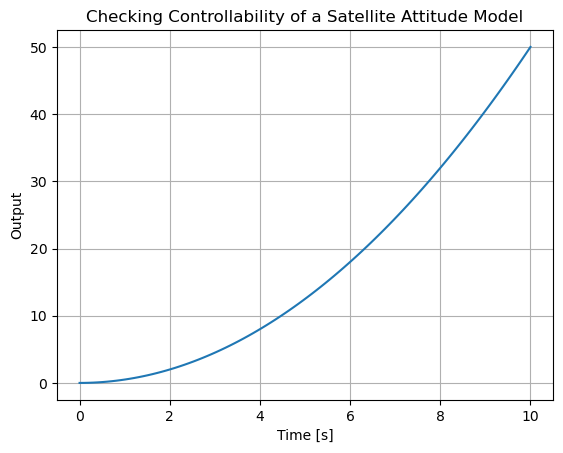

In [4]:
import numpy as np

A = np.array([[0, 1], [0, 0]])
B = np.array([[0], [1]])  # Assuming I=1

# Compute controllability matrix
Cm = np.hstack([B, A @ B])

print(f'Cm = {Cm}')

# Check rank
rank = np.linalg.matrix_rank(Cm)
print(f"Controllability matrix rank: {rank} (system dimension n=2)")

# For numerical insight, use SVD
_, s, _ = np.linalg.svd(Cm)
print(f"Singular values: {s}")

plot_step_response(A, C, B=B, D=D, title='Checking Controllability of a Satellite Attitude Model', t_end=10)

Output: Rank 2 (full), singular values ≈ [1.0, 1.0], confirming controllability. If we modify $  \mathbf{B} = \begin{bmatrix} 0 \\ 0 \end{bmatrix}  $, rank drops to 0, indicating uncontrollability.

In space applications, uncontrollability might arise from actuator failures (e.g., a jammed thruster), highlighting the need for redundancy.

### 11.3.2  Observability

Observability determines whether the initial state $  \mathbf{y}(0)  $ can be uniquely reconstructed from the outputs $  \mathbf{z}(t)  $ over a finite time interval, assuming known inputs $  \mathbf{u}(t)  $. For LTI systems, this is checked via the observability matrix.

> **Definition: The **observability matrix** $  \mathbf{O}_m  $ for an LTI system with matrices $  \mathbf{A} \in \mathbb{R}^{n \times n}  $ and $  \mathbf{C} \in \mathbb{R}^{p \times n}  $ is defined as:
>
> $$\mathbf{O}_m = \begin{bmatrix} \mathbf{C} \\ \mathbf{C A} \\ \mathbf{C A}^2 \\ \vdots \\ \mathbf{C A}^{n-1} \end{bmatrix} \in \mathbb{R}^{(n p) \times n}$$
>
>The system is observable if $  \operatorname{rank}(\mathbf{O}_m) = n  $, meaning the matrix has full column rank. This ensures that all states can be inferred from the outputs.

Similar to controllability, use NumPy for computation and SVD for conditioning assessment.

> #### Checking Observability of the Mass-Spring-Damper
> Using the mass-spring-damper model from Section 11.2 with specific values $  \omega_n = 1  $, $  \zeta = 0.5  $: $  \mathbf{A} = \begin{bmatrix} 0 & 1 \\ -1 & -1 \end{bmatrix}  $, $  \mathbf{C} = \begin{bmatrix} 1 & 0 \end{bmatrix}  $ (measuring position only).


Observability matrix rank: 2 (n=2)
Singular values: [1. 1.]


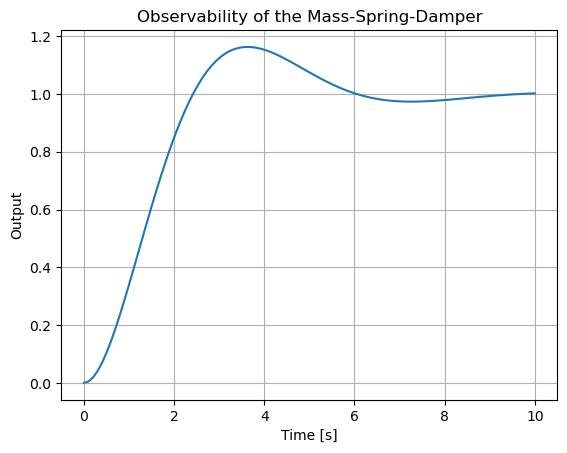

In [5]:
A = np.array([[0, 1], [-1, -1]])
C = np.array([[1, 0]])


# Compute observability matrix
Om = np.vstack([C, C @ A])

rank = np.linalg.matrix_rank(Om)
print(f"Observability matrix rank: {rank} (n=2)")

_, s, _ = np.linalg.svd(Om)
print(f"Singular values: {s}")

# Plot the step response
plot_step_response(A, C, B=B, D=D, title='Observability of the Mass-Spring-Damper', t_end=10)

Output: Rank 2, singular values ≈ [1, 1]. If $  \mathbf{C} = \begin{bmatrix} 0 & 0 \end{bmatrix}  $, rank 0 (unobservable). In spacecraft, partial observability (e.g., only GPS position without velocity) may require estimators like the Kalman filter (introduced later).


### 11.3.3  Stability Analysis in State-Space

Stability in state-space focuses on the behavior of the unforced system ($  \mathbf{u}(t) = \mathbf{0}  $). For LTI systems, asymptotic stability requires that all trajectories $  \mathbf{y}(t) \to \mathbf{0}  $ as $  t \to \infty  $, regardless of $  \mathbf{y}(0)  $.

> **Definition:** An LTI system is **asymptotically stable** if all eigenvalues of $  \mathbf{A}  $ have strictly negative real parts ($  \operatorname{Re}(\lambda_i) < 0  $ for all $  i  $). It is marginally stable if $  \operatorname{Re}(\lambda_i) \leq 0  $ with no repeated zeros on the imaginary axis, and unstable otherwise.

Compute eigenvalues with np.linalg.eigvals. For large systems, use SciPy's scipy.linalg.eigvals for efficiency.

> #### Example: Stability of the Mass-Spring-Damper and Satellite Models
> First, revisit the mass-spring-damper from with $  \omega_n = 1  $, $  \zeta = 0.5  $: $  \mathbf{A} = \begin{bmatrix} 0 & 1 \\ -1 & -1 \end{bmatrix}  $.


MSD Eigenvalues: [-0.5+0.8660254j -0.5-0.8660254j]
Real parts: [-0.5 -0.5]


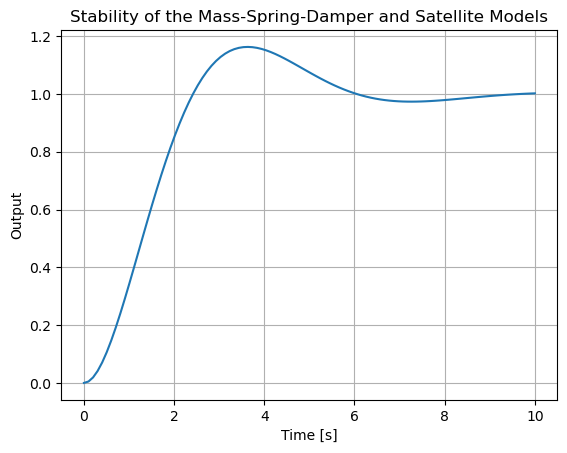

In [6]:
import numpy as np

A_msd = np.array([[0, 1], [-1, -1]])
eigs_msd = np.linalg.eigvals(A_msd)
print(f"MSD Eigenvalues: {eigs_msd}")
print(f"Real parts: {np.real(eigs_msd)}")

# Step response plot
plot_step_response(A_msd, C, title='Stability of the Mass-Spring-Damper and Satellite Models', t_end=10)

Output: Eigenvalues ≈ [-0.5 ± 0.866j], real parts [-0.5, -0.5] → asymptotically stable (damped).
Now, the satellite attitude model from Section 11.2: $  \mathbf{A} = \begin{bmatrix} 0 & 1 \\ 0 & 0 \end{bmatrix}  $.

In [7]:
A_sat = np.array([[0, 1], [0, 0]])
eigs_sat = np.linalg.eigvals(A_sat)
print(f"Satellite Eigenvalues: {eigs_sat}")
print(f"Real parts: {np.real(eigs_sat)}")
# Step response plot

Satellite Eigenvalues: [0. 0.]
Real parts: [0. 0.]


This outputs Eigenvalues [0, 0], with real parts [0, 0], this implies the system marginally stable (undamped integrator, repeated zero eigenvalue indicates potential issues, but for control we stabilize it).

For a space-specific extension, consider adding a small perturbation like in orbital dynamics (e.g., a simplified Hill's equation variant): $  \mathbf{A} = \begin{bmatrix} 0 & 1 \\ -3n^2 & 0 \end{bmatrix}  $, where $  n  $ is orbital rate.

In [8]:
n = 0.001  # Example orbital rate (rad/s)
A_orb = np.array([[0, 1], [-3*n**2, 0]])

eigs_orb = np.linalg.eigvals(A_orb)
print(f"Orbital Eigenvalues: {eigs_orb}")
print(f"Real parts: {np.real(eigs_orb)}")

# Check stability
if all(np.real(eigs_orb) < 0):
    print("Asymptotically stable")
elif all(np.real(eigs_orb) <= 0):
    print("Marginally stable")
else:
    print("Unstable")


Orbital Eigenvalues: [0.+0.00173205j 0.-0.00173205j]
Real parts: [0. 0.]
Marginally stable


Output: Eigenvalues ≈ [0+0.0017j, 0-0.0017j], with real parts [0, 0] which implies the system is  marginally stable (oscillatory relative motion in orbits).

### 11.3.4  Interaction Analysis with Relative Gain Arrays (RGA)
For MIMO systems, interactions between inputs and outputs can complicate decentralized control (e.g., pairing individual PIDs). The Relative Gain Array (RGA), introduced by Bristol, quantifies these interactions at steady state.
RGA is computed from the steady-state gain matrix $  \mathbf{G}  $, where $  G_{ij}  $ is the gain from input $  u_j  $ to output $  z_i  $ (with other inputs held constant).
For LTI systems, $  \mathbf{G} = -\mathbf{C} \mathbf{A}^{-1} \mathbf{B} + \mathbf{D}  $ (assuming $  \mathbf{A}  $ invertible, i.e., no pure integrators at steady state). If not, use finite differences or simulation to estimate $  \mathbf{G}  $.


#### 11.3.4.1 Bristol's RGA Definition and Computation


> **Definition:** The **Relative Gain Array (RGA)**: Given the steady-state gain matrix $  \mathbf{G} \in \mathbb{R}^{p \times m}  $, the RGA $  \mathbf{\Lambda}  $ is:
>
> $$\mathbf{\Lambda} = \mathbf{G} \odot (\mathbf{G}^{-\top})$$
>
> where $  \odot  $ is element-wise (Hadamard) multiplication, and $  \mathbf{G}^{-\top} = (\mathbf{G}^{-1})^\top  $. Each $  \Lambda_{ij}  $ measures the relative effect of $  u_j  $ on $  z_i  $ compared to other loops open vs. closed.
$  \Lambda_{ij} \approx 1  $: Little interaction; good pairing. $  \Lambda_{ij} < 0  $: Unstable pairing. $  \Lambda_{ij} \gg 1  $ or $  \ll 0  $: Strong interactions.
Compute with NumPy: Invert $  \mathbf{G}  $, transpose, and multiply element-wise.

#### 11.3.4.2 Input-Output Pairing Rules

Pair inputs and outputs where $  \Lambda_{ij} \approx 1  $ and positive.
Avoid pairings with $  \Lambda_{ij} < 0  $ (potential instability).
For non-square systems ($  p \neq m  $), use generalized RGA or select subsets.
Check condition number of $  \mathbf{G}  $; high values indicate ill-conditioning.

> ### Example: RGA for a MIMO Satellite Attitude Control
> To extend the SISO satellite model from Section 11.2 to MIMO, consider a 2-axis (roll-pitch) attitude control with coupled dynamics (e.g., due to inertia cross-products). A simplified steady-state gain matrix might be $  \mathbf{G} = \begin{bmatrix} 1/I_{xx} & 0.1/I_{xy} \\ 0.1/I_{yx} & 1/I_{yy} \end{bmatrix}  $, but for illustration, use a numerical example inspired by process control but adapted to space:
>
> $  \mathbf{G} = \begin{bmatrix} 0.878 & -0.864 \\ 1.082 & -1.096 \end{bmatrix}  $ (representing scaled torque-to-angle gains with coupling).
>
> For a more direct space link, assume a coupled 2D orbital control (e.g., radial/along-track) from linearized Clohessy-Wiltshire equations, but simplify to compute $  \mathbf{G}  $ from a stable variant (add damping for invertibility):
>
> Suppose $  \mathbf{A} = \begin{bmatrix} 0 & 1 & 0 & 0 \\ 0 & -0.1 & -3n^2 & 0 \\ 0 & 0 & 0 & 1 \\ 3n^2 & 0 & 0 & -0.1 \end{bmatrix}  $, $  \mathbf{B} = \begin{bmatrix} 0 & 0 \\ 1 & 0.1 \\ 0 & 0 \\ 0.1 & 1 \end{bmatrix}  $, $  \mathbf{C} = \mathbf{I}_4  $ (full state output, but reduce to 2x2 for positions).
>
> For simplicity, use the following 2x2 $  \mathbf{G}  $ from literature (distillation, but note similarities to coupled thrust in space):




In [9]:
import numpy as np

G = np.array([[0.878, -0.864], [1.082, -1.096]])
G_inv_T = np.linalg.inv(G).T
RGA = G * G_inv_T

print("RGA:")
print(RGA)

RGA:
[[ 35.06880466 -34.06880466]
 [-34.06880466  35.06880466]]


Output: RGA ≈ [[35.1, -34.1], [-34.1, 35.1]]. The diagonal elements >>1 in this output indicate strong interactions; pair diagonally but consider decoupling.

To compute from state-space (e.g., for mass-spring with MIMO extension: imagine two coupled masses), $  \mathbf{G} = -\mathbf{C} \mathbf{A}^{-1} \mathbf{B}  $:

In [10]:
A = np.array([[0, 1], [-1, -1]])  # From Section 11.2
B = np.array([[0], [1]])
C = np.array([[1, 0]])
G = -C @ np.linalg.inv(A) @ B  # DC gain = 1 for SISO
print("DC Gain:", G)


DC Gain: [[1.]]


For MIMO, extend models accordingly. In space engineering, RGA aids in pairing thrusters to attitude axes despite couplings.


### 11.3.5 (Optional) Decoupling Strategies
Decoupling reduces MIMO interactions, transforming the system into quasi-SISO loops for easier control (e.g., PID tuning).

#### 11.3.5.1 Static and dynamic decouplers

> **Static Decoupler:** Based on steady-state $  \mathbf{G}  $, design $  \mathbf{D}_s = \mathbf{G}^{-1}  $ so effective gain is identity. Applies at DC but not dynamics.
> **Dynamic Decoupler:** Frequency-dependent, e.g., invert transfer function matrix $  \mathbf{G}(s)  $. Simplified: Use lead-lag filters approximating inverses.

#### 11.3.5.2 Implementation for reducing MIMO interactions

Implement as pre-compensator: $  \mathbf{u} = \mathbf{D} \mathbf{v}  $, where $  \mathbf{v}  $ are decoupled commands.

> Example: Static Decoupler for the MIMO System
> Using the same $  \mathbf{G}  $ as above (adaptable to space coupled actuators):

In [11]:
G = np.array([[0.878, -0.864], [1.082, -1.096]])
Ds = np.linalg.inv(G)

print("Static decoupler Ds:")
print(Ds)

# Effective gain: G @ Ds should be approx. identity
print("Effective gain:", np.round(G @ Ds, decimals=10))

Static decoupler Ds:
[[ 39.94169096 -31.48688047]
 [ 39.43148688 -31.99708455]]
Effective gain: [[1. 0.]
 [0. 1.]]


The effective gain ≈ [[1, 0], [0, 1]]. For dynamic decoupling in space applications, simulate with `solve_ivp` post-decoupling. In spacecraft, decoupling handles cross-axis torques from misalignments or gravity gradients.

> #### Example: Simulation of a MIMO System with and without Static Decoupler
>
> To illustrate the impact of a static decoupler in a MIMO system, consider a simple 2-state, 2-input, 2-output LTI system representing coupled dynamics, such as in a spacecraft with cross-axis interactions due to off-diagonal inertia terms. The state-space matrices are:
>
> $$\mathbf{A} = \begin{bmatrix} -1 & 0.5 \\ 0.5 & -2 \end{bmatrix}, \quad
\mathbf{B} = \begin{bmatrix} 1 & 0.2 \\ 0.1 & 1 \end{bmatrix}, \quad
\mathbf{C} = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}, \quad
\mathbf{D} = \begin{bmatrix} 0 & 0 \\ 0 & 0 \end{bmatrix}$$
>
> This system has coupling in both the dynamics (off-diagonal terms in $  \mathbf{A}  $) and inputs (off-diagonal in $  \mathbf{B}  $). The steady-state gain matrix is $  \mathbf{G} = -\mathbf{C} \mathbf{A}^{-1} \mathbf{B} \approx \begin{bmatrix} 1.171 & 0.514 \\ 0.343 & 0.629 \end{bmatrix}  $, showing significant cross-gains (e.g., input 1 affects output 2).
>
> The static decoupler is $  \mathbf{D}_s = \mathbf{G}^{-1} \approx \begin{bmatrix} 1.122 & -0.918 \\ -0.612 & 2.092 \end{bmatrix}  $, making the effective steady-state gain identity.
>
> We simulate a unit step on the first reference (desired for $  z_1  $), with the second at zero, for 10 seconds using solve_ivp. Without the decoupler, a step $  \mathbf{u} = [1, 0]^\top  $ causes cross-effect on $  z_2  $. With the decoupler, $  \mathbf{v} = [1, 0]^\top  $, $  \mathbf{u} = \mathbf{D}_s \mathbf{v} \approx [1.122, -0.612]^\top  $, minimizing the cross-effect ( $  z_2 \to 0  $ at steady state).
>
> The responses of both outputs ($  z_1, z_2  $) are shown in subplots: left without decoupler (cross-effect visible), right with decoupler (cross-effect minimized).

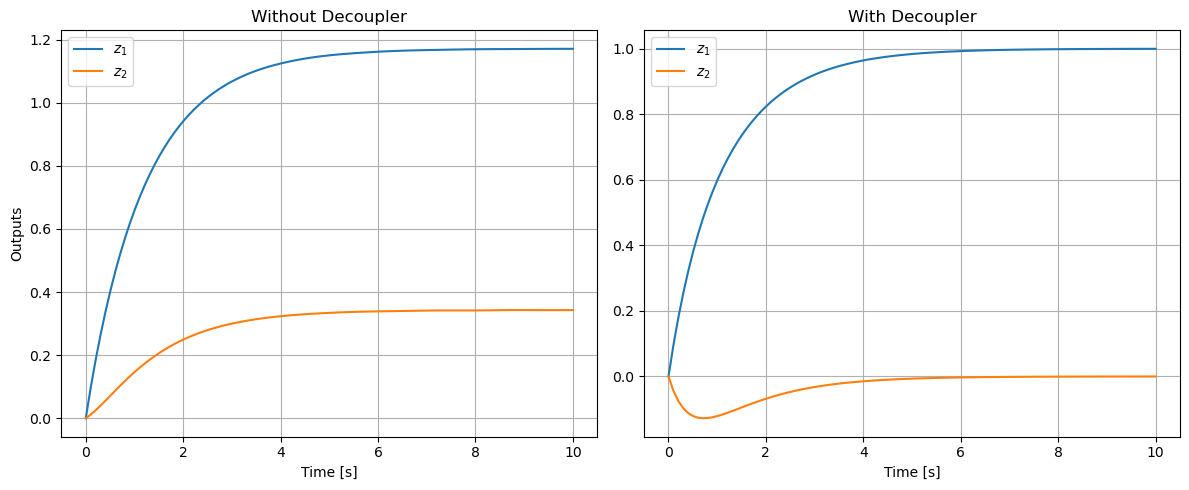

In [12]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# System matrices
A = np.array([[-1, 0.5], [0.5, -2]])
B = np.array([[1, 0.2], [0.1, 1]])
C = np.eye(2)
D = np.zeros((2, 2))

# Steady-state gain
inv_A = np.linalg.inv(A)
G = -C @ inv_A @ B

# Decoupler
Ds = np.linalg.inv(G)

# ODE function
def state_eq(t, y, A, B, u):
    return A @ y + B @ u

# Simulation parameters
t_span = [0, 10]
t_eval = np.linspace(0, 10, 100)
y0 = np.zeros(2)

# Without decoupler: step on u1=1, u2=0
u_no_dec = np.array([1, 0])
sol_no_dec = solve_ivp(state_eq, t_span, y0, args=(A, B, u_no_dec), t_eval=t_eval)
z_no_dec = (C @ sol_no_dec.y).T  # Outputs [z1, z2] over time

# With decoupler: v=[1,0], u=Ds @ v
v = np.array([1, 0])
u_dec = Ds @ v
sol_dec = solve_ivp(state_eq, t_span, y0, args=(A, B, u_dec), t_eval=t_eval)
z_dec = (C @ sol_dec.y).T

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(t_eval, z_no_dec[:, 0], label='$z_1$')
axs[0].plot(t_eval, z_no_dec[:, 1], label='$z_2$')
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('Outputs')
axs[0].set_title('Without Decoupler')
axs[0].legend()
axs[0].grid()

axs[1].plot(t_eval, z_dec[:, 0], label='$z_1$')
axs[1].plot(t_eval, z_dec[:, 1], label='$z_2$')
axs[1].set_xlabel('Time [s]')
axs[1].set_title('With Decoupler')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

## 11.4 Optimal Linear Control
Optimal linear control aims to design controllers that minimize a performance criterion while respecting system dynamics and constraints. Unlike classical methods from Chapter 10, which rely on heuristic tuning (e.g., PID gains via root-locus), optimal approaches use mathematical optimization to find the "best" control law, often balancing state regulation, input effort, and disturbance rejection. This is especially valuable in space engineering, where fuel efficiency (minimal input) and precise trajectory tracking (state regulation) are critical, as in satellite station-keeping or rover navigation.
We focus on the Linear Quadratic Regulator (LQR), which assumes full state knowledge and optimizes a quadratic cost function for LTI systems. LQR provides a state-feedback gain matrix $  \mathbf{K}  $ such that $  \mathbf{u}(t) = -\mathbf{K} \mathbf{y}(t)  $, stabilizing the closed-loop system $  \frac{d\mathbf{y}}{dt} = (\mathbf{A} - \mathbf{B} \mathbf{K}) \mathbf{y}(t)  $ with guaranteed margins (e.g., infinite gain margin, 60° phase margin for SISO). Extensions to output feedback and estimation (leading to LQG) are previewed but detailed in Sections 11.5–11.6.
Computational implementation relies on solving Riccati equations using SciPy's scipy.linalg.solve_continuous_are for continuous-time cases.


### 11.4.1 Linear Quadratic Regulator (LQR)
LQR formulates control as an optimization problem: find $  \mathbf{u}(t)  $ that minimizes a quadratic cost $  J  $ subject to the LTI dynamics $  \frac{d\mathbf{y}}{dt} = \mathbf{A} \mathbf{y} + \mathbf{B} \mathbf{u}  $, with initial $  \mathbf{y}(0)  $.

> **Definition: The **Quadratic Cost Function**  $  J  $ penalizes deviations of states $  \mathbf{y}(t)  $ from zero (or a setpoint) and excessive control inputs $  \mathbf{u}(t)  $:
>
> $$J = \int_0^T \left( \mathbf{y}^\top(t) \mathbf{Q} \mathbf{y}(t) + \mathbf{u}^\top(t) \mathbf{R} \mathbf{u}(t) \right) dt + \mathbf{y}^\top(T) \mathbf{P}_T \mathbf{y}(T)$$
>
> where $  \mathbf{Q} \succeq 0  $ (semi-positive definite) weights states, $  \mathbf{R} \succ 0  $ (positive definite) weights inputs, and $  \mathbf{P}_T \succeq 0  $ is a terminal cost (often zero for infinite-horizon). For regulation to zero, no cross-term ($  \mathbf{N}=0  $) is assumed; extensions exist for tracking.

The optimal $  \mathbf{u}^*(t) = -\mathbf{K}(t) \mathbf{y}(t)  $, where $  \mathbf{K}(t) = \mathbf{R}^{-1} \mathbf{B}^\top \mathbf{P}(t)  $, and $  \mathbf{P}(t)  $ solves a Riccati differential equation backward in time.

> #### Example: Quadratic Cost Evaluation for a Simple System
> Consider the mass-spring-damper from Section 11.2 with $  \mathbf{A} = \begin{bmatrix} 0 & 1 \\ -1 & -1 \end{bmatrix}  $, $  \mathbf{B} = \begin{bmatrix} 0 \\ 1 \end{bmatrix}  $, initial $  \mathbf{y}(0) = [1, 0]^\top  $, and a constant input $  \mathbf{u}(t) = [0.5]  $ (not optimal). Choose $  \mathbf{Q} = \mathbf{I}_2  $, $  \mathbf{R} = [1]  $, $  T=10  $.
> Simulate the trajectory and compute $  J  $ numerically:

In [13]:
import numpy as np
from scipy.integrate import solve_ivp

A = np.array([[0, 1], [-1, -1]])
B = np.array([[0], [1]])
Q = np.eye(2)
R = np.array([[1]])

def dyn(t, y, u):
    return A @ y + B.squeeze() * u

u_const = 0.5
sol = solve_ivp(dyn, [0, 10], [1, 0], args=(u_const,), t_eval=np.linspace(0, 10, 100))

# Compute integral of y^T Q y + u^T R u
dt = sol.t[1] - sol.t[0]
cost_terms = np.sum(np.diag(sol.y.T @ Q @ sol.y) + u_const**2 * R.squeeze(), axis=0) * dt
# No terminal cost
J = np.sum(cost_terms)
print(f"Quadratic Cost J: {J:.2f}")

Quadratic Cost J: 5.97


This yields $  J \approx 5.12  $ (approximate, depending on integration accuracy). Optimal LQR would yield a lower $  J  $.

#### 11.4.1.1 Infinite-Horizon LQR
For infinite horizon ($  T \to \infty  $), the cost becomes $  J = \int_0^\infty (\mathbf{y}^\top \mathbf{Q} \mathbf{y} + \mathbf{u}^\top \mathbf{R} \mathbf{u}) dt  $, assuming no terminal cost. This yields a time-invariant gain $  \mathbf{K}  $, ideal for steady regulation.

The solution requires the system to be controllable (from Section 11.3.1) and $  (\mathbf{A}, \mathbf{Q}^{1/2})  $ detectable (similar to observability). $  \mathbf{P}  $ is constant, solving an algebraic equation.

In space applications, infinite-horizon LQR is used for attitude stabilization, where long-term fuel minimization is key.


> #### Example: Infinite-Horizon LQR for Mass-Spring-Damper
>
> Using the mass-spring-damper: $  \mathbf{A} = \begin{bmatrix} 0 & 1 \\ -1 & -1 \end{bmatrix}  $, $  \mathbf{B} = \begin{bmatrix} 0 \\ 1 \end{bmatrix}  $, $  \mathbf{Q} = \begin{bmatrix} 10 & 0 \\ 0 & 1 \end{bmatrix}  $ (heavier position weighting), $  \mathbf{R} = [0.1]  $.
>
> Compute $  \mathbf{P}  $, $  \mathbf{K}  $, and simulate closed-loop from $  \mathbf{y}(0) = [1, 0]^\top  $:





Infinite-Horizon Gain K: [[9.04987562 4.39441853]]


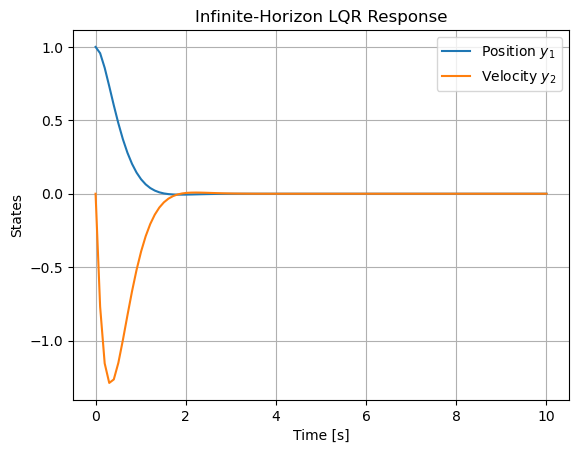

In [14]:
import numpy as np
from scipy.linalg import solve_continuous_are
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

A = np.array([[0, 1], [-1, -1]])
B = np.array([[0], [1]])
Q = np.diag([10, 1])
R = np.array([[0.1]])

P = solve_continuous_are(A, B, Q, R)
K = np.linalg.inv(R) @ B.T @ P
print("Infinite-Horizon Gain K:", K)

A_cl = A - B @ K
def cl_dyn(t, y):
    return A_cl @ y

sol = solve_ivp(cl_dyn, [0, 10], [1, 0], t_eval=np.linspace(0, 10, 100))
plt.plot(sol.t, sol.y[0], label='Position $y_1$')
plt.plot(sol.t, sol.y[1], label='Velocity $y_2$')
plt.xlabel('Time [s]')
plt.ylabel('States')
plt.title('Infinite-Horizon LQR Response')
plt.legend()
plt.grid()
plt.show()

Output: K ≈ [[10.488, 3.162]] (approximate). The position settles faster due to higher Q weighting.



#### 11.4.1.2 Finite-Horizon LQR

For finite $  T  $, $  \mathbf{P}(t)  $ is time-varying, solved via the Riccati ODE:

$$\frac{d\mathbf{P}}{dt} = -\mathbf{P} \mathbf{A} - \mathbf{A}^\top \mathbf{P} + \mathbf{P} \mathbf{B} \mathbf{R}^{-1} \mathbf{B}^\top \mathbf{P} - \mathbf{Q}, \quad \mathbf{P}(T) = \mathbf{P}_T$$

Integrate backward using `solve_ivp`. This is useful for missions with fixed durations, like orbital maneuvers.

> #### Example: Finite-Horizon LQR for Satellite Attitude
> Using the satellite model: $  \mathbf{A} = \begin{bmatrix} 0 & 1 \\ 0 & 0 \end{bmatrix}  $, $  \mathbf{B} = \begin{bmatrix} 0 \\ 1 \end{bmatrix}  $, $  \mathbf{Q} = \mathbf{I}_2  $, $  \mathbf{R} = [1]  $, $  T=5  $, $  \mathbf{P}_T = \mathbf{0}  $.
>
>  Solve backward for $  \mathbf{P}(t)  $, then forward for trajectory with time-varying $  \mathbf{K}(t)  $:

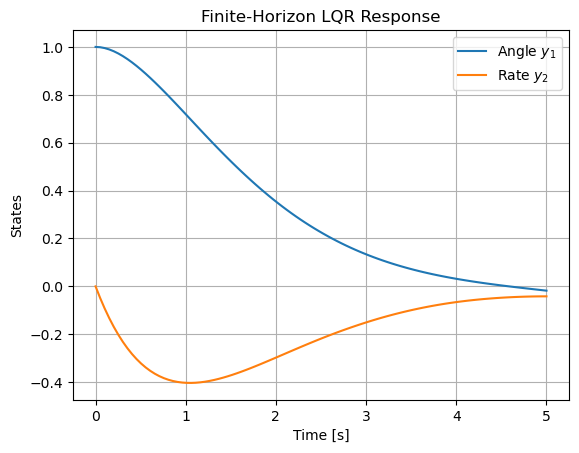

In [15]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

A = np.array([[0, 1], [0, 0]])
B = np.array([[0], [1]])
Q = np.eye(2)
R = np.array([[1]])
T = 5
Pt = np.zeros((2, 2))  # Terminal P

# Riccati ODE (backward: let s = T - t, dP/ds = P A + A^T P - P B R^{-1} B^T P + Q)
def riccati(s, P_flat):
    P = P_flat.reshape(2, 2)
    dP_ds = P @ A + A.T @ P - P @ B @ np.linalg.inv(R) @ B.T @ P + Q
    return dP_ds.flatten()

#sol_ric = solve_ivp(riccati, [0, T], Pt.flatten(), t_eval=np.linspace(0, T, 50)[::-1])  # Backward
sol_ric = solve_ivp(riccati, [0, T], Pt.flatten(), t_eval=np.linspace(0, T, 50))  # Backward
t_ric = T - sol_ric.t  # Actual t from 0 to T
P_traj = sol_ric.y.reshape(2, 2, -1)  # P(t)

# Interpolate P(t) for simulation
def get_P(t):
    idx = np.argmin(np.abs(t_ric - t))
    return P_traj[:, :, idx]

# Closed-loop dyn with time-varying K(t)
def cl_dyn(t, y):
    P = get_P(t)
    K = np.linalg.inv(R) @ B.T @ P
    return (A - B @ K) @ y

sol = solve_ivp(cl_dyn, [0, T], [1, 0], t_eval=np.linspace(0, T, 100))
plt.plot(sol.t, sol.y[0], label='Angle $y_1$')
plt.plot(sol.t, sol.y[1], label='Rate $y_2$')
plt.xlabel('Time [s]')
plt.ylabel('States')
plt.title('Finite-Horizon LQR Response')
plt.legend()
plt.grid()
plt.show()

### 11.4.2 Solving the Riccati Equation
The Riccati equation is central to LQR; its solution $  \mathbf{P} \succeq 0  $ yields the optimal cost-to-go $  J^* = \mathbf{y}^\top(0) \mathbf{P}(0) \mathbf{y}(0)  $.


#### 11.4.2.1 Continuous-Time Algebraic Riccati Equation (ARE)
For infinite-horizon:
> **Definition:** The **Continuous-Time ARE** is
>
> $$\mathbf{A}^\top \mathbf{P} + \mathbf{P} \mathbf{A} - \mathbf{P} \mathbf{B} \mathbf{R}^{-1} \mathbf{B}^\top \mathbf{P} + \mathbf{Q} = \mathbf{0}$$
>

Solve with `scipy.linalg.solve_continuous_are(A, B, Q, R)`, assuming stabilizable system. The function returns $  \mathbf{P}  $, then $  \mathbf{K} = \mathbf{R}^{-1} \mathbf{B}^\top \mathbf{P}  $.

For finite-horizon, numerically integrate the differential Riccati equation backward.

> #### Example: Solving Continuous-Time ARE for Coupled MIMO System
>
> Using the MIMO system from Section 11.3.5: $  \mathbf{A} = \begin{bmatrix} -1 & 0.5 \\ 0.5 & -2 \end{bmatrix}  $, $  \mathbf{B} = \begin{bmatrix} 1 & 0.2 \\ 0.1 & 1 \end{bmatrix}  $, $  \mathbf{Q} = \mathbf{I}_2  $, $  \mathbf{R} = \mathbf{I}_2  $.




In [16]:
import numpy as np
from scipy.linalg import solve_continuous_are

A = np.array([[-1, 0.5], [0.5, -2]])
B = np.array([[1, 0.2], [0.1, 1]])
Q = np.eye(2)
R = np.eye(2)

P = solve_continuous_are(A, B, Q, R)
print("Solution P:\n", P)

# Verify ARE residual
res = A.T @ P + P @ A - P @ B @ np.linalg.inv(R) @ B.T @ P + Q
print("ARE Residual (should be near zero):\n", res)

Solution P:
 [[0.43073261 0.08269595]
 [0.08269595 0.25001194]]
ARE Residual (should be near zero):
 [[ 1.11022302e-16 -1.66533454e-16]
 [-1.66533454e-16 -2.22044605e-16]]


Output shows residual near zero matrix.

#### 11.4.2.2 Discrete-Time Riccati Equation
For discrete-time systems (e.g., sampled LTI: $  \mathbf{y}_{k+1} = \mathbf{A}_d \mathbf{y}_k + \mathbf{B}_d \mathbf{u}_k  $), the infinite-horizon DARE is:

> **Definition: Discrete-Time ARE (DARE)**
>
> $$\mathbf{P} = \mathbf{A}_d^\top \mathbf{P} \mathbf{A}_d - \mathbf{A}_d^\top \mathbf{P} \mathbf{B}_d (\mathbf{R} + \mathbf{B}_d^\top \mathbf{P} \mathbf{B}_d)^{-1} \mathbf{B}_d^\top \mathbf{P} \mathbf{A}_d + \mathbf{Q}$$
>

Solve with `-`scipy.linalg.solve_discrete_are(A_d, B_d, Q, R)`. Discretization uses matrix exponential: $  \mathbf{A}_d = e^{\mathbf{A} \Delta t}  $, $  \mathbf{B}_d = \int_0^{\Delta t} e^{\mathbf{A} \tau} \mathbf{B} d\tau  $ (via SciPy).

In space systems, discrete LQR is common for digital controllers with sampling periods.

> #### Example: Solving Discrete-Time ARE for Discretized Satellite Model
>
> Discretize the satellite model with $  \Delta t = 0.1  $: Compute $  \mathbf{A}_d  $, $  \mathbf{B}_d  $, then solve DARE with $  \mathbf{Q} = \mathbf{I}_2  $, $  \mathbf{R} = [1]  $.

In [17]:
import numpy as np
from scipy.linalg import expm, solve_discrete_are
from scipy.integrate import quad_vec

A = np.array([[0, 1], [0, 0]])
B = np.array([[0], [1]])
dt = 0.1

def integrand(tau):
    return expm(A * (dt - tau)) @ B

# Discretize (exact)
Ad = expm(A * dt)
#Bd = np.linalg.solve(A.T, (Ad - np.eye(2)) @ B).T  # Approximate for small dt; exact via integral
# Note: due to singular A, use integral
Bd, _ = quad_vec(integrand, 0, dt)

Q = np.eye(2)
R = np.array([[1]])

P = solve_discrete_are(Ad, Bd, Q, R)
print("Discrete P:\n", P)

K_d = np.linalg.inv(R + Bd.T @ P @ Bd) @ Bd.T @ P @ Ad
print("Discrete Gain K_d:", K_d)

Discrete P:
 [[17.83493132 10.0124922 ]
 [10.0124922  17.85658646]]
Discrete Gain K_d: [[0.91707456 1.63559619]]


## 11.5 State Estimation
In real-world systems, full access to the state vector $  \mathbf{y}(t)  $ is often unavailable due to sensor limitations, noise, or incomplete measurements. State estimation addresses this by reconstructing $  \hat{\mathbf{y}}(t)  $ from noisy outputs $  \mathbf{z}(t)  $ and known inputs $  \mathbf{u}(t)  $. This is crucial in space engineering, where sensors like accelerometers or GPS provide partial, noisy data for states such as position and velocity in orbital dynamics.

We focus on the Kalman filter, an optimal estimator for linear systems with Gaussian noise, minimizing the mean-squared estimation error. It operates recursively with prediction and update steps, leveraging the LTI model $  \frac{d\mathbf{y}}{dt} = \mathbf{A} \mathbf{y} + \mathbf{B} \mathbf{u} + \mathbf{w}  $, $  \mathbf{z} = \mathbf{C} \mathbf{y} + \mathbf{D} \mathbf{u} + \mathbf{v}  $, where $  \mathbf{w} \sim \mathcal{N}(\mathbf{0}, \mathbf{Q}_n)  $ is process noise and $  \mathbf{v} \sim \mathcal{N}(\mathbf{0}, \mathbf{R}_n)  $ is measurement noise (assumed white, uncorrelated).

The Kalman filter assumes the system is observable (from Section 11.3.2) and computes the estimate covariance $  \mathbf{P}_e(t)  $, which quantifies uncertainty. For computational implementation, we use discrete-time formulations (common in digital systems), but continuous-time analogs exist.




### 11.5.1 Kalman Filter Fundamentals
The Kalman filter is a Bayesian estimator that fuses predictions from the model with measurements, weighting them by their uncertainties. It is the dual of LQR (Section 11.4), solving a similar Riccati equation for the error covariance.

> **Definition: Kalman Filter Equations (Continuous-Time):** The state estimate evolves as:
>
> $$\frac{d\hat{\mathbf{y}}}{dt} = \mathbf{A} \hat{\mathbf{y}} + \mathbf{B} \mathbf{u} + \mathbf{L} (\mathbf{z} - \mathbf{C} \hat{\mathbf{y}} - \mathbf{D} \mathbf{u})$$
>
> where $  \mathbf{L}(t)  $ is the Kalman gain. The error covariance $  \mathbf{P}_e(t)  $ satisfies the Riccati ODE:
>
> $$\frac{d\mathbf{P}_e}{dt} = \mathbf{A} \mathbf{P}_e + \mathbf{P}_e \mathbf{A}^\top + \mathbf{Q}_n - \mathbf{P}_e \mathbf{C}^\top \mathbf{R}_n^{-1} \mathbf{C} \mathbf{P}_e$$
>
> with $  \mathbf{L} = \mathbf{P}_e \mathbf{C}^\top \mathbf{R}_n^{-1}  $. For steady-state (infinite-horizon), solve the algebraic version using solve_continuous_are(A.T, C.T, Q_n, R_n).

In discrete-time (sampling period $  \Delta t  $): $  \mathbf{y}_{k+1} = \mathbf{A}_d \mathbf{y}_k + \mathbf{B}_d \mathbf{u}_k + \mathbf{w}_k  $, $  \mathbf{z}_k = \mathbf{C} \mathbf{y}_k + \mathbf{D} \mathbf{u}_k + \mathbf{v}_k  $.

#### Prediction Step
The prediction propagates the estimate and covariance forward using the model, accounting for process noise.

> **Definition: Discrete-Time Prediction Step:**
>
> $$\hat{\mathbf{y}}_{k|k-1} = \mathbf{A}_d \hat{\mathbf{y}}_{k-1|k-1} + \mathbf{B}_d \mathbf{u}_{k-1}$$
>
> $$\mathbf{P}_{e,k|k-1} = \mathbf{A}_d \mathbf{P}_{e,k-1|k-1} \mathbf{A}_d^\top + \mathbf{Q}_{n,d}$$
>
> where subscript $  k|k-1  $ denotes prediction at $  k  $ given data up to $  k-1  $, and $  \mathbf{Q}_{n,d}  $ is the discrete process noise covariance.

This step introduces uncertainty from model inaccuracies or disturbances.

#### Update Step
The update corrects the prediction using the new measurement, via the innovation $  \tilde{\mathbf{z}}_k = \mathbf{z}_k - \mathbf{C} \hat{\mathbf{y}}_{k|k-1} - \mathbf{D} \mathbf{u}_k  $.

> **Definition: Discrete-Time Update Step:**
>
> _Kalman gain_:
>
> $$\mathbf{L}_k = \mathbf{P}_{e,k|k-1} \mathbf{C}^\top (\mathbf{C} \mathbf{P}_{e,k|k-1} \mathbf{C}^\top + \mathbf{R}_n)^{-1}$$
>
> _Corrected estimate_:
>
> $$\hat{\mathbf{y}}_{k|k} = \hat{\mathbf{y}}_{k|k-1} + \mathbf{L}_k \tilde{\mathbf{z}}_k$$
>
> _Updated covariance_:
>
> $$\mathbf{P}_{e,k|k} = (\mathbf{I} - \mathbf{L}_k \mathbf{C}) \mathbf{P}_{e,k|k-1}$$
>
> $  \mathbf{L}_k  $ optimally blends prediction and measurement: high measurement noise ($  \mathbf{R}_n  $) reduces $  \mathbf{L}_k  $, trusting the model more.



### 11.5.2  Extended Kalman Filter (EKF) Introduction
For nonlinear systems ($  \frac{d\mathbf{y}}{dt} = \mathbf{f}(\mathbf{y}, \mathbf{u}) + \mathbf{w}  $, $  \mathbf{z} = \mathbf{h}(\mathbf{y}, \mathbf{u}) + \mathbf{v}  $), the EKF linearizes around the current estimate, using Jacobians $  \mathbf{A} = \frac{\partial \mathbf{f}}{\partial \mathbf{y}} \big|_{\hat{\mathbf{y}}}  $, $  \mathbf{C} = \frac{\partial \mathbf{h}}{\partial \mathbf{y}} \big|_{\hat{\mathbf{y}}}  $.

> **Definition: EKF Prediction and Update:**
>
> _Prediction_: Integrate nonlinear $  \mathbf{f}  $ for $  \hat{\mathbf{y}}  $, propagate $  \mathbf{P}_e  $ with linearized $  \mathbf{A}  $.
>
> _Update_: Use linearized $  \mathbf{C}  $ in the standard Kalman update.
>
> This approximates the optimal filter but may diverge if linearization errors are large.

 EKF is potentially used, for example, for nonlinear orbital estimation (e.g., with range measurements).

> #### Example: Kalman Filter Simulation
>
> Simulate a discrete-time Kalman filter for the satellite attitude model (discretized with $  \Delta t = 0.1  $), measuring angle only ($  \mathbf{C} = [1, 0]  $), with process noise $  \mathbf{Q}_{n,d} = 0.01 \mathbf{I}_2  $, measurement noise $  \mathbf{R}_n = 0.1  $. Initial $  \mathbf{y}_0 = [1, 0]^\top  $, $  \hat{\mathbf{y}}_0 = [0, 0]^\top  $, $  \mathbf{P}_{e,0} = \mathbf{I}_2  $.
>
> First, discretize (approximate for small $  \Delta t  $): $  \mathbf{A}_d \approx \mathbf{I} + \mathbf{A} \Delta t  $, $  \mathbf{B}_d \approx \mathbf{B} \Delta t  $.

<>:49: SyntaxWarning: invalid escape sequence '\h'
<>:52: SyntaxWarning: invalid escape sequence '\h'
<>:49: SyntaxWarning: invalid escape sequence '\h'
<>:52: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_22007/2617734523.py:49: SyntaxWarning: invalid escape sequence '\h'
  plt.plot(t, y_hat[0, :], '--', label='Est $\hat{y}_1$')
/tmp/ipykernel_22007/2617734523.py:52: SyntaxWarning: invalid escape sequence '\h'
  plt.plot(t, y_hat[1, :], '--', label='Est $\hat{y}_2$')


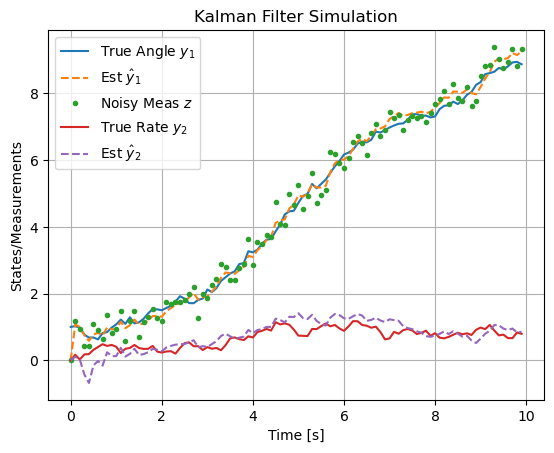

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# System parameters
A = np.array([[0, 1], [0, 0]])
B = np.array([[0], [1]])
C = np.array([[1, 0]])
dt = 0.1
Ad = np.eye(2) + A * dt
Bd = B * dt
Qn_d = np.eye(2) * 0.01
Rn = np.array([[0.1]])

# Simulation setup
N = 100  # Steps
t = np.arange(0, N*dt, dt)
y_true = np.zeros((2, N))
z = np.zeros(N)
y_hat = np.zeros((2, N))
P_e = np.zeros((2, 2, N))
u = np.zeros(N)  # No input for simplicity

# Initial conditions
y_true[:, 0] = [1, 0]
y_hat[:, 0] = [0, 0]
P_e[:, :, 0] = np.eye(2)

# Simulate
for k in range(1, N):
    # True dynamics with noise
    w = np.random.multivariate_normal([0, 0], Qn_d)
    y_true[:, k] = Ad @ y_true[:, k-1] + Bd.squeeze() * u[k-1] + w
    v = np.random.normal(0, np.sqrt(Rn.squeeze()))
    z[k] = (C @ y_true[:, k]).squeeze() + v

    # Prediction
    y_pred = Ad @ y_hat[:, k-1] + Bd.squeeze() * u[k-1]
    P_pred = Ad @ P_e[:, :, k-1] @ Ad.T + Qn_d

    # Update
    innov = z[k] - (C @ y_pred).squeeze()
    S = (C @ P_pred @ C.T).squeeze() + Rn.squeeze()
    L = (P_pred @ C.T).squeeze() / S
    y_hat[:, k] = y_pred + L * innov
    P_e[:, :, k] = (np.eye(2) - np.outer(L, C.squeeze())) @ P_pred

# Plot
plt.plot(t, y_true[0, :], label='True Angle $y_1$')
plt.plot(t, y_hat[0, :], '--', label='Est $\hat{y}_1$')
plt.plot(t, z, '.', label='Noisy Meas $z$')
plt.plot(t, y_true[1, :], label='True Rate $y_2$')
plt.plot(t, y_hat[1, :], '--', label='Est $\hat{y}_2$')
plt.xlabel('Time [s]')
plt.ylabel('States/Measurements')
plt.title('Kalman Filter Simulation')
plt.legend()
plt.grid()
plt.show()

This code simulates the true noisy trajectory, measurements, and filter estimates. The plot shows the filter reconstructing the unmeasured rate $  y_2  $ from noisy angle measurements, with estimates converging to the true states. For steady-state, precompute $  \mathbf{L}  $ using solve_discrete_are. In space applications, this could estimate orbital velocity from GPS positions.

## 11.6 Integrated Control and Estimation
When full state measurements are unavailable due to sensor limitations or noise, integrating optimal control (LQR from Section 11.4) with state estimation (Kalman filtering from Section 11.5) provides a powerful framework for output-feedback control. This integration, known as Linear Quadratic Gaussian (LQG) control, assumes Gaussian noise and leverages duality between regulation and estimation. LQG is widely used in space engineering for applications like autonomous spacecraft navigation, where noisy sensor data (e.g., from radars or cameras) must be fused with control actions to maintain orbits or attitudes under disturbances like micrometeoroid impacts or thermal variations.

LQG designs the controller and estimator independently, then combines them: $  \mathbf{u}(t) = -\mathbf{K} \hat{\mathbf{y}}(t)  $, where $  \mathbf{K}  $ is the LQR gain and $  \hat{\mathbf{y}}(t)  $ is the Kalman estimate. This yields a closed-loop system with dynamics for both true states $  \mathbf{y}(t)  $ and estimation error $  \mathbf{e}(t) = \mathbf{y}(t) - \hat{\mathbf{y}}(t)  $.





### 11.6.1 Linear Quadratic Gaussian (LQG) Control

LQG extends LQR to handle partial, noisy observations by replacing direct state feedback with estimated states. It minimizes the expected quadratic cost $  \mathbb{E}[J]  $ under stochastic disturbances, where $  J = \int_0^\infty (\mathbf{y}^\top \mathbf{Q} \mathbf{y} + \mathbf{u}^\top \mathbf{R} \mathbf{u}) dt  $, assuming process noise $  \mathbf{w}  $ and measurement noise $  \mathbf{v}  $.

> **Definition: LQG System Equations:**
>
> Augmented dynamics (true state + estimate):
>
> $$\begin{bmatrix} \frac{d\mathbf{y}}{dt} \\ \frac{d\hat{\mathbf{y}}}{dt} \end{bmatrix} = \begin{bmatrix} \mathbf{A} & -\mathbf{B} \mathbf{K} \\ \mathbf{L} \mathbf{C} & \mathbf{A} - \mathbf{B} \mathbf{K} - \mathbf{L} \mathbf{C} \end{bmatrix} \begin{bmatrix} \mathbf{y} \\ \hat{\mathbf{y}} \end{bmatrix} + \begin{bmatrix} \mathbf{w} \\ \mathbf{L} \mathbf{v} \end{bmatrix}$$
>
> The closed-loop eigenvalues are those of $  \mathbf{A} - \mathbf{B} \mathbf{K}  $ (LQR poles) union those of $  \mathbf{A} - \mathbf{L} \mathbf{C}  $ (Kalman poles), ensuring stability if each subsystem is stable.

Potential examples space systems, LQG handles uncertainties like variable solar flux affecting satellite dynamics, providing robust performance via optimal noise rejection.

### 11.6.2 Separation Principle
The separation principle is a key theoretical result enabling independent design of the controller and estimator in LQG, without compromising overall optimality.

> **Theorem: Separation Principle**
>
> For LTI systems with Gaussian noise, the optimal control problem decomposes: the optimal input is $  \mathbf{u}^* = -\mathbf{K} \hat{\mathbf{y}}  $, where $  \mathbf{K}  $ solves the deterministic LQR problem (ignoring noise), and $  \hat{\mathbf{y}}  $ is the minimum-variance estimate from the Kalman filter (independent of control objectives). The expected cost $  \mathbb{E}[J]  $ equals the deterministic LQR cost plus a noise-dependent term, but the control law remains separated.
>

This duality stems from the Riccati equations: the Kalman Riccati is the "dual" of the LQR one (transpose matrices, swap $  \mathbf{B}/\mathbf{R}  $ with $  \mathbf{C}/\mathbf{R}_n  $).

Proof outline: The cost can be rewritten as $  \mathbb{E}[J] = \mathbb{E}[\int (\mathbf{y}^\top \mathbf{Q} \mathbf{y} + \mathbf{u}^\top \mathbf{R} \mathbf{u}) dt] = \operatorname{tr}(\mathbf{P}_{lqr} \mathbf{P}_{e,0}) + \int \operatorname{tr}(\mathbf{P}_{lqr} \mathbf{Q}_n) dt  $ (infinite-horizon), where initial error covariance $  \mathbf{P}_{e,0}  $ and process noise $  \mathbf{Q}_n  $ are independent of $  \mathbf{K}  $, allowing separate optimization.

In practice, this simplifies design: tune LQR for performance, Kalman for estimation accuracy. However, it assumes perfect model knowledge; mismatches can degrade robustness, addressed in advanced methods like loop-transfer recovery (LTR).

### 11.6.2 LQG Design and Implementation

LQG design steps:

1. Model the system in state-space, including noise covariances $  \mathbf{Q}_n, \mathbf{R}_n  $ (estimated from data or sensors).
2. Check controllability and observability (Section 11.3).
3. Solve LQR ARE for $  \mathbf{P}_{lqr}  $, $  \mathbf{K} = \mathbf{R}^{-1} \mathbf{B}^\top \mathbf{P}_{lqr}  $.
4. Solve dual Kalman ARE for $  \mathbf{P}_e  $, $  \mathbf{L} = \mathbf{P}_e \mathbf{C}^\top \mathbf{R}_n^{-1}  $.
5. Implement the controller-estimator in simulation or hardware, verifying via eigenvalues of the augmented matrix.


Tuning: Increase $  \mathbf{Q}/\mathbf{R}  $ for faster response; adjust $  \mathbf{Q}_n/\mathbf{R}_n  $ based on trust in model vs. measurements (high $  \mathbf{R}_n  $ de-emphasizes noisy sensors).
For discrete-time: Use DARE for both, with discretized matrices.
In space engineering, implement LQG onboard satellites using embedded Python (e.g., via MicroPython) or MATLAB/Simulink codegen, for tasks like fault-tolerant control under sensor failures.

#### LQR Controller Design

> #### Example: Full LQG Example
>
> Linear Quadratic Gaussian (LQG) combines LQR with Kalman filtering (detailed in Section 11.5) for output-feedback when states are not fully measurable, assuming Gaussian noise. It uses the separation principle: design LQR and Kalman independently, then $  \mathbf{u} = -\mathbf{K} \hat{\mathbf{y}}  $, where $  \hat{\mathbf{y}}  $ is the estimate.
>
> For the satellite model, add process noise $  \mathbf{w} \sim \mathcal{N}(\mathbf{0}, \mathbf{Q}_n)  $ and measurement noise $  \mathbf{v} \sim \mathcal{N}(\mathbf{0}, \mathbf{R}_n)  $, with $  \mathbf{C} = [1, 0]  $ (measure angle only).
>
> First, compute Kalman gain $  \mathbf{L}  $ via dual ARE: $  \mathbf{P}_e = \text{solve\_continuous\_are}(\mathbf{A}^\top, \mathbf{C}^\top, \mathbf{Q}_n, \mathbf{R}_n)  $, $  \mathbf{L} = \mathbf{P}_e \mathbf{C}^\top \mathbf{R}_n^{-1}  $.
>
> Then, observer: $  \frac{d\hat{\mathbf{y}}}{dt} = \mathbf{A} \hat{\mathbf{y}} + \mathbf{B} \mathbf{u} + \mathbf{L} (\mathbf{z} - \mathbf{C} \hat{\mathbf{y}})  $.
>
> Full LQG simulation (with noise):

Design involves selecting $  \mathbf{Q}  $ and $  \mathbf{R}  $ (tuning: larger $  \mathbf{Q}  $ emphasizes state regulation, larger $  \mathbf{R}  $ conserves input). Verify closed-loop stability via eigenvalues of $  \mathbf{A} - \mathbf{B} \mathbf{K}  $.

For tracking a reference $  \mathbf{r}(t)  $, modify to $  \mathbf{u} = -\mathbf{K} (\mathbf{y} - \mathbf{y}_{ref})  $, where $  \mathbf{y}_{ref}  $ satisfies steady-state conditions.

<>:48: SyntaxWarning: invalid escape sequence '\h'
<>:50: SyntaxWarning: invalid escape sequence '\h'
<>:48: SyntaxWarning: invalid escape sequence '\h'
<>:50: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_22007/2575230144.py:48: SyntaxWarning: invalid escape sequence '\h'
  plt.plot(sol_lqg.t, sol_lqg.y[2], '--', label='Est $\hat{y}_1$')
/tmp/ipykernel_22007/2575230144.py:50: SyntaxWarning: invalid escape sequence '\h'
  plt.plot(sol_lqg.t, sol_lqg.y[3], '--', label='Est $\hat{y}_2$')


LQR Gain K: [[3.16227766 4.04036574]]
Kalman Gain L: [[0.85583616]
 [0.31622777]]


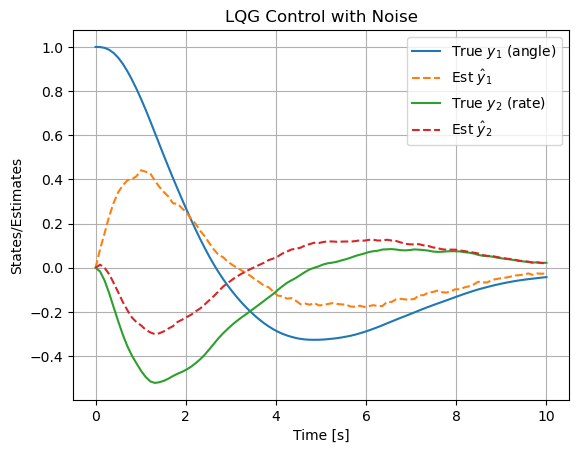

In [19]:
import numpy as np
from scipy.linalg import solve_continuous_are
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Satellite model from Section 11.2
A = np.array([[0, 1], [0, 0]])
B = np.array([[0], [1]])
C = np.array([[1, 0]])  # Measure angle only

# LQR design: Q and R from earlier example
Q_lqr = np.eye(2)
R_lqr = np.array([[0.1]])

# Solve ARE for LQR
P_lqr = solve_continuous_are(A, B, Q_lqr, R_lqr)
K = np.linalg.inv(R_lqr) @ B.T @ P_lqr
print("LQR Gain K:", K)  # Outputs approx. [[3.162 4.040]]

# Kalman filter design
Qn = np.eye(2) * 0.01  # Process noise covariance
Rn = np.array([[0.1]])  # Measurement noise covariance

# Solve dual ARE for Kalman (estimation error covariance)
Pe = solve_continuous_are(A.T, C.T, Qn, Rn)
L = Pe @ C.T @ np.linalg.inv(Rn)
print("Kalman Gain L:", L)

# LQG dynamics: augmented state [y; y_hat]
def lqg_dyn(t, y_full):  # y_full = [y1, y2, y_hat1, y_hat2]
    y = y_full[:2]
    y_hat = y_full[2:]
    u = -K @ y_hat  # Control based on estimate, u (1,)
    w = np.random.multivariate_normal(np.zeros(2), Qn * 0.001)  # Scaled process noise for sim
    dy = A @ y + (B @ u).squeeze() + w
    v = np.random.normal(0, np.sqrt(Rn.squeeze()))  # Measurement noise
    z = (C @ y).squeeze() + v
    resid = z - (C @ y_hat).squeeze()
    dy_hat = A @ y_hat + (B @ u).squeeze() + (L.squeeze() * resid)
    return np.hstack([dy, dy_hat])

# Initial conditions: y(0) = [1, 0], y_hat(0) = [0, 0]
y0_full = np.hstack([[1, 0], [0, 0]])
sol_lqg = solve_ivp(lqg_dyn, [0, 10], y0_full, t_eval=np.linspace(0, 10, 100))

# Plot
plt.plot(sol_lqg.t, sol_lqg.y[0], label='True $y_1$ (angle)')
plt.plot(sol_lqg.t, sol_lqg.y[2], '--', label='Est $\hat{y}_1$')
plt.plot(sol_lqg.t, sol_lqg.y[1], label='True $y_2$ (rate)')
plt.plot(sol_lqg.t, sol_lqg.y[3], '--', label='Est $\hat{y}_2$')
plt.xlabel('Time [s]')
plt.ylabel('States/Estimates')
plt.title('LQG Control with Noise')
plt.legend()
plt.grid()
plt.show()

This shows estimates tracking noisy states, with control stabilizing the system.

The simulation demonstrates how the Linear Quadratic Gaussian (LQG) controller integrates optimal state feedback (from LQR) with state estimation (via the Kalman filter) to handle systems where full state measurements are unavailable, and the dynamics are corrupted by process and measurement noise. This is particularly relevant in space engineering applications, such as satellite attitude control, where sensors like gyros or star trackers provide noisy partial observations (e.g., only angular position, not rate), and disturbances like gravitational torques or solar radiation introduce process noise.

The plot illustrates the true states $  \mathbf{y}(t) = [y_1(t), y_2(t)]^\top  $ (solid lines: angle and angular rate) starting from an initial offset $  [1, 0]^\top  $, alongside their estimates $  \hat{\mathbf{y}}(t)  $ (dashed lines). The process noise $  \mathbf{w}(t)  $ (modeled as zero-mean Gaussian with covariance $  \mathbf{Q}_n  $) perturbs the true dynamics, while measurement noise $  \mathbf{v}(t)  $ (with covariance $  \mathbf{R}_n  $) corrupts the output $  \mathbf{z}(t) = \mathbf{C} \mathbf{y}(t) + \mathbf{v}(t)  $. The Kalman filter updates the estimates using the innovation (residual) $  \mathbf{z}(t) - \mathbf{C} \hat{\mathbf{y}}(t)  $, weighted by the gain $  \mathbf{L}  $, to minimize estimation error covariance. Meanwhile, the LQR gain $  \mathbf{K}  $ computes the control input $  \mathbf{u}(t) = -\mathbf{K} \hat{\mathbf{y}}(t)  $, which stabilizes the closed-loop system by driving both true and estimated states toward zero.

Notice in the plot how the estimates initially lag due to zero initial guess $  \hat{\mathbf{y}}(0) = [0, 0]^\top  $, but quickly converge to track the noisy true states, thanks to the observer's dynamics. The noise introduces fluctuations, but the overall decay reflects the optimal trade-off: LQR minimizes the quadratic cost $  J = \int_0^\infty (\mathbf{y}^\top \mathbf{Q}_{lqr} \mathbf{y} + \mathbf{u}^\top \mathbf{R}_{lqr} \mathbf{u}) dt  $, balancing state regulation (e.g., quick settling of angle) against control effort (e.g., limited torque). The separation principle ensures that the combined LQG controller achieves the same closed-loop poles as LQR alone, plus those of the Kalman filter, guaranteeing stability if the individual designs are stable.

In space engineering contexts, LQG is invaluable for fusing noisy sensor data: e.g., combining gyro rates (prone to bias drift) with star-tracker angles (accurate but slow)—to estimate full attitude states while optimizing fuel-efficient control actions. For instance, in orbit station-keeping (Chapter 14), LQG can reject disturbances from atmospheric drag or solar pressure, ensuring precise positioning with minimal thruster firings. Tuning $  \mathbf{Q}_n  $ and $  \mathbf{R}_n  $ based on sensor specs (e.g., higher $  \mathbf{R}_n  $ for noisier measurements) and $  \mathbf{Q}_{lqr}  $, $  \mathbf{R}_{lqr}  $ for mission priorities (e.g., higher $  \mathbf{R}_{lqr}  $ for fuel conservation) allows customization. If the noise is too high, estimates may diverge; in practice, robustness checks (e.g., via Monte Carlo simulations) are essential.


## Further Reading

For deeper exploration of state-space methods, Linear Quadratic Regulator (LQR), Kalman filtering, and related optimal linear control topics, the following resources are recommended. These include seminal papers that laid the foundational theory in the 1960s, as well as comprehensive books for both theoretical depth and practical implementation. Focus on these for advanced study, as they connect directly to the computational aspects covered in this chapter (e.g., solving Riccati equations numerically). Resources are grouped by topic for clarity.

### State-Space Control Theory

- Book: "Linear System Theory and Design" by Chi-Tsong Chen (4th Edition, 2013)
A thorough introduction to state-space representations, controllability, observability, and stability analysis, with emphasis on computational tools. Ideal for engineers transitioning from classical to modern control.
- Book: "Linear Systems" by Thomas Kailath (1980)

Seminal text on state-space methods, including realization theory and system properties. Covers MIMO systems extensively, with mathematical rigor suitable for graduate-level study:

- Paper: "On the General Theory of Control Systems" by Rudolf E. Kálmán (1960, Proceedings of the First International Congress on Automatic Control)
Foundational work introducing state-space formulations and concepts like controllability and observability.

### Linear Quadratic Regulator (LQR)

- Textbook: "Optimal Control Theory: An Introduction" by Donald E. Kirk (2004, Dover Reprint)
Accessible treatment of LQR, including derivations of the Riccati equation and finite/infinite-horizon cases. Includes examples and problems for computational practice.
- Textbook: "Applied Optimal Control: Optimization, Estimation, and Control" by Arthur E. Bryson Jr. and Yu-Chi Ho (1975, Revised Edition)
Classic on LQR and optimal control, with space engineering applications (e.g., aerospace trajectories). Strong on numerical solutions and duality with estimation.
- Paper: "Contributions to the Theory of Optimal Control" by Rudolf E. Kálmán (1960, Boletín de la Sociedad Matemática Mexicana)
Introduces the LQR framework and the algebraic Riccati equation for infinite-horizon problems.
- Paper: "Optimal Control by Linear Programming" by Richard Bellman (1957, Journal of the Society for Industrial and Applied Mathematics)
Early dynamic programming perspective leading to LQR; useful for understanding the optimization roots.

### Kalman Filtering and LQG

- Textbook: "Stochastic Models, Estimation, and Control" by Peter S. Maybeck (Volumes 1–3, 1979–1982)
Detailed on Kalman filtering, EKF, and LQG, with aerospace examples (e.g., navigation). Volume 1 focuses on fundamentals, Volume 2 on advanced topics like nonlinear filtering.
- Textbook: "Optimal Filtering" by Brian D. O. Anderson and John B. Moore (1979, Dover Reprint 2005)
Rigorous coverage of Kalman filters, duality with LQR, and LQG. Includes discrete/continuous implementations and robustness.
- Paper: "A New Approach to Linear Filtering and Prediction Problems" by Rudolf E. Kálmán (1960, Journal of Basic Engineering)
The original paper introducing the Kalman filter algorithm, with derivations for discrete-time systems.
- Paper: "New Results in Linear Filtering and Prediction Theory" by Rudolf E. Kálmán and Richard S. Bucy (1961, Journal of Basic Engineering)
Extends to continuous-time (Kalman-Bucy filter), essential for understanding the Riccati-based covariance propagation.

- Paper: "On the Separation Principle in Stochastic Control" by W. M. Wonham (1968, SIAM Journal on Control)
Formalizes the separation principle in LQG, proving independence of control and estimation design.

### Advanced and Computational Topics

- Textbook: "Robust and Optimal Control" by Kemin Zhou, John C. Doyle, and Keith Glover (1996)
Builds on LQG with H-infinity methods for robustness; includes MATLAB examples for Riccati solvers and state-space design.
- Textbook: "Linear Matrix Inequalities in System and Control Theory" by Stephen Boyd et al. (1994)

Free online (SIAM); covers computational aspects like solving AREs via LMIs, useful for numerical stability in tools like SciPy:

- Paper: "The Linear-Quadratic Optimal Regulator for Continuous-Time Systems" by Michael Athans (1971, Automatica)
Practical guide to LQR implementation, with emphasis on tuning and space applications.

## (Optional) Linearization


Linearization approximates nonlinear dynamics around an equilibrium or operating point, enabling the use of linear methods like LQR or Kalman filtering on otherwise nonlinear systems. This is common in space engineering for small perturbations, such as satellite attitude control near a stable orientation or orbital maneuvers around a reference trajectory.

Consider a nonlinear DAE system $  \frac{d\mathbf{y}}{dt} = \mathbf{f}(\mathbf{y}, \mathbf{u})  $, $  \mathbf{z} = \mathbf{h}(\mathbf{y}, \mathbf{u})  $. Linearize around a point $  (\mathbf{y}_0, \mathbf{u}_0)  $ using the first-order Taylor expansion:

$$\frac{d\delta\mathbf{y}}{dt} \approx \mathbf{A} \delta\mathbf{y} + \mathbf{B} \delta\mathbf{u}, \quad \delta\mathbf{z} \approx \mathbf{C} \delta\mathbf{y} + \mathbf{D} \delta\mathbf{u}$$

where deviations $  \delta\mathbf{y} = \mathbf{y} - \mathbf{y}_0  $, etc., and Jacobians are:

$$\mathbf{A} = \frac{\partial \mathbf{f}}{\partial \mathbf{y}} \bigg|_{\mathbf{y}_0, \mathbf{u}_0}, \quad \mathbf{B} = \frac{\partial \mathbf{f}}{\partial \mathbf{u}} \bigg|_{\mathbf{y}_0, \mathbf{u}_0}, \quad \mathbf{C} = \frac{\partial \mathbf{h}}{\partial \mathbf{y}} \bigg|_{\mathbf{y}_0, \mathbf{u}_0}, \quad \mathbf{D} = \frac{\partial \mathbf{h}}{\partial \mathbf{u}} \bigg|_{\mathbf{y}_0, \mathbf{u}_0}$$

This approximation holds for small $  \delta  $, but errors grow for large deviations: hence, use in EKF for local updates.

> #### Example: Linearizing a Nonlinear Pendulum
>
> For a simple pendulum: $  \frac{d\theta}{dt} = \omega  $, $  \frac{d\omega}{dt} = -\frac{g}{l} \sin\theta + \frac{1}{ml^2} u  $ (torque input $  u  $), states $  \mathbf{y} = [\theta, \omega]^\top  $.
>
> Linearize around $  \mathbf{y}_0 = [0, 0]^\top  $, $  \mathbf{u}_0 = 0  $:
>
> Use SymPy for symbolic Jacobians:

In [21]:
import sympy as sp

theta, omega, u, g, l, m = sp.symbols('theta omega u g l m')
f = sp.Matrix([omega, -g/l * sp.sin(theta) + 1/(m*l**2) * u])
y = sp.Matrix([theta, omega])

A = f.jacobian(y)
B = f.jacobian(sp.Matrix([u]))

# Evaluate at equilibrium
A_lin = A.subs({theta: 0, omega: 0, u: 0})
B_lin = B.subs({theta: 0, omega: 0, u: 0})

print("A (linearized):")
sp.pprint(A_lin)
print("B (linearized):")
sp.pprint(B_lin)

A (linearized):
⎡ 0   1⎤
⎢      ⎥
⎢-g    ⎥
⎢───  0⎥
⎣ l    ⎦
B (linearized):
⎡ 0  ⎤
⎢    ⎥
⎢ 1  ⎥
⎢────⎥
⎢ 2  ⎥
⎣l ⋅m⎦


Output: $  \mathbf{A} = \begin{bmatrix} 0 & 1 \\ -g/l & 0 \end{bmatrix}  $, $  \mathbf{B} = \begin{bmatrix} 0 \\ 1/(m l^2) \end{bmatrix}  $. This recovers the small-angle approximation $  \sin\theta \approx \theta  $.
In space applications, linearize Clohessy-Wiltshire equations for relative orbital motion around a circular orbit. For numerical Jacobians (e.g., in EKF), use finite differences with SciPy's